# Lung Segmentation Using the Montgomery Dataset

[[Paper](https://arxiv.org/abs/1505.04597)] [[Notebook](https://github.com/fastestimator/fastestimator/blob/master/apphub/semantic_segmentation/unet/unet.ipynb)] [[TF Implementation](https://github.com/fastestimator/fastestimator/blob/master/apphub/semantic_segmentation/unet/unet_tf.py)] [[Torch Implementation](https://github.com/fastestimator/fastestimator/blob/master/apphub/semantic_segmentation/unet/unet_torch.py)]

In [1]:
import os
import tempfile
from typing import Any, Dict, List

import cv2
import numpy as np
import pandas as pd
import torch

import fastestimator as fe
from fastestimator.architecture.pytorch import UNet
from fastestimator.dataset.data import montgomery
from fastestimator.op.numpyop import Delete, NumpyOp
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, Resize, Rotate
from fastestimator.op.numpyop.univariate import Minmax, ReadImage, Reshape
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice
from fastestimator.util import ImageDisplay, GridDisplay

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
batch_size = 4
epochs = 25
train_steps_per_epoch = None
eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
data_dir = None

# Download Data

We download the Montgomery data first:

In [4]:
csv = montgomery.load_data(root_dir=data_dir)

This creates a `CSVDataset`. Let's see what is inside:

In [5]:
df = pd.DataFrame.from_dict(csv.data, orient='index')

In [6]:
df.head()

,image,mask_left,mask_right
0,MontgomerySet/CXR_png/MCUCXR_0383_1.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0383_1.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0383_1.png
1,MontgomerySet/CXR_png/MCUCXR_0255_1.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0255_1.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0255_1.png
2,MontgomerySet/CXR_png/MCUCXR_0016_0.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0016_0.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0016_0.png
3,MontgomerySet/CXR_png/MCUCXR_0182_1.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0182_1.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0182_1.png
4,MontgomerySet/CXR_png/MCUCXR_0338_1.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0338_1.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0338_1.png


# Building Components

Now let's set the stage for training:

## Step 1: Create `Pipeline`

In [7]:
class CombineLeftRightMask(NumpyOp):
    def forward(self, data: List[np.ndarray], state: Dict[str, Any]) -> List[np.ndarray]:
        mask_left, mask_right = data
        data = np.maximum(mask_left, mask_right)
        return data

In [8]:
pipeline = fe.Pipeline(
    train_data=csv,
    eval_data=csv.split(0.2),
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="image", parent_path=csv.parent_path, outputs="image", color_flag="gray"),
        ReadImage(inputs="mask_left", parent_path=csv.parent_path, outputs="mask_left", color_flag="gray", mode='!infer'),
        ReadImage(inputs="mask_right",
                  parent_path=csv.parent_path,
                  outputs="mask_right",
                  color_flag="gray",
                  mode='!infer'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask", mode='!infer'),
        Delete(keys=["mask_left", "mask_right"], mode='!infer'),
        Resize(image_in="image", width=512, height=512),
        Resize(image_in="mask", width=512, height=512, mode='!infer'),
        Sometimes(numpy_op=HorizontalFlip(image_in="image", mask_in="mask", mode='train')),
        Sometimes(numpy_op=Rotate(
            image_in="image", mask_in="mask", limit=(-10, 10), border_mode=cv2.BORDER_CONSTANT, mode='train')),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask", mode='!infer'),
        Reshape(shape=(1, 512, 512), inputs="image", outputs="image"),
        Reshape(shape=(1, 512, 512), inputs="mask", outputs="mask", mode='!infer')
    ])

Let's see if the `Pipeline` output is reasonable. We call `get_results` to get outputs from `Pipeline`.

In [9]:
batch_data = pipeline.get_results()

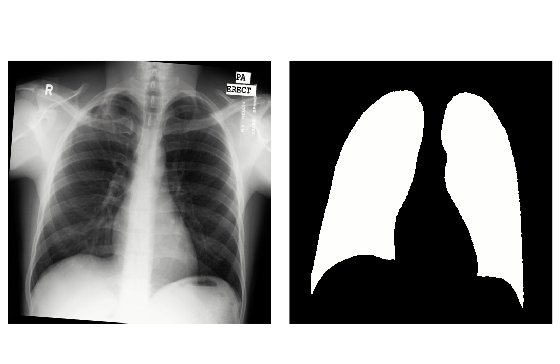

In [10]:
batch_index = 1
GridDisplay([ImageDisplay(image=np.squeeze(batch_data['image'][batch_index])), 
             ImageDisplay(image=np.squeeze(batch_data['mask'][batch_index]))
            ]).show()

## Step 2: Create `Network`

In [11]:
model = fe.build(
    model_fn=lambda: UNet(input_size=(1, 512, 512)),
    optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
    model_name="lung_segmentation"
)

In [12]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    CrossEntropy(inputs=("pred_segment", "mask"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

## Step 3: Create `Estimator`

In [13]:
traces = [
    Dice(true_key="mask", pred_key="pred_segment"),
    BestModelSaver(model=model, save_dir=save_dir, metric='Dice', save_best_mode='max')
]

In [14]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=epochs,
                         log_steps=20,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)

# Training

In [15]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 20; num_device: 1;
FastEstimator-Train: step: 1; loss: 0.61223024;
FastEstimator-Train: step: 20; loss: 0.3766136; steps/sec: 7.9;
FastEstimator-Train: step: 28; epoch: 1; epoch_time: 11.86 sec;
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 7.82;
Eval Progress: 4/7; steps/sec: 13.23;
Eval Progress: 7/7; steps/sec: 16.75;
FastEstimator-BestModelSaver: Saved model to /tmp/tmp22fq9j1i/lung_segmentation_best_Dice.pt
FastEstimator-Eval: step: 28; epoch: 1; Dice: 0.8265303; loss: 0.2719451; max_Dice: 0.826530

Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 7.92;
Eval Progress: 4/7; steps/sec: 16.38;
Eval Progress: 7/7; steps/sec: 13.81;
FastEstimator-Eval: step: 476; epoch: 17; Dice: 0.9618596; loss: 0.049392406; max_Dice: 0.96931; since_best_Dice: 3;
FastEstimator-Train: step: 480; loss: 0.10188608; steps/sec: 1.88;
FastEstimator-Train: step: 500; loss: 0.06218755; steps/sec: 8.36;
FastEstimator-Train: step: 504; epoch: 18; epoch_time: 11.62 sec;
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 7.89;
Eval Progress: 4/7; steps/sec: 12.78;
Eval Progress: 7/7; steps/sec: 11.01;
FastEstimator-BestModelSaver: Saved model to /tmp/tmp22fq9j1i/lung_segmentation_best_Dice.pt
FastEstimator-Eval: step: 504; epoch: 18; Dice: 0.9720732; loss: 0.03817087; max_Dice: 0.9720732; since_best_Dice: 0;
FastEstimator-Train: step: 520; loss: 0.08881314; steps/sec: 1.86;
FastEstimator-Train: step: 532; epoch: 19; epoch_time: 11.7 sec;
Eval Progress: 1/7;
Eval Progress: 2/7; steps/sec: 7.32;
Eval Progress: 4/

# Inferencing

Let's visualize the prediction from the neural network. We select a random image from the dataset:

In [16]:
image_path = df['image'].sample(random_state=3).values[0]

## Pass the image through `Pipeline` and `Network`

We create a data dict, and call `Pipeline.transform()`.

In [17]:
data = {'image': image_path}
data = pipeline.transform(data, mode="infer")

After the `Pipeline`, we rebuild our model by providing the trained weights path and pass it to a new `Network`:

In [18]:
weights_path = os.path.join(save_dir, "lung_segmentation_best_Dice.pt") # your model_path

model = fe.build(model_fn=lambda: UNet(input_size=(1, 512, 512)),
                 optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=0.0001),
                 model_name="lung_segmentation",
                 weights_path=weights_path)

In [19]:
network = fe.Network(ops=[ModelOp(inputs="image", model=model, outputs="pred_segment")])

We call `Network.transform()` to get outputs from our `Network`:

In [20]:
pred = network.transform(data, mode="infer")

## Visualize Outputs

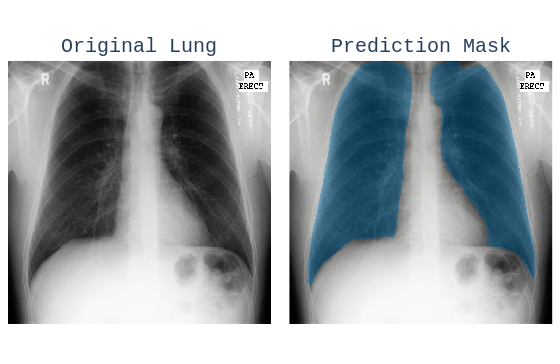

In [21]:
img = np.squeeze(pred['image'].numpy())
mask = np.squeeze(1.0 * (pred['pred_segment'] > 0.5))

GridDisplay([ImageDisplay(image=img, title="Original Lung"), 
             ImageDisplay(image=img, masks=mask, title="Prediction Mask")]).show()